# Setting up sparkContext in pyspark

Start a pySpark session including third party packages (SCALA version: 2.11) which will pull from Maven repository:
- __spark-root_2.11:0.1.16__ 
- __histogrammar-sparksql_2.11:1.0.4__

Declares external dependency to the Spark application, in case we are using:

- __XrootD-Connector__

The default cores (defaults at 4) for every spark application is bottlenecked by __SPARK_MASTER_OPTS__ predefined in spark-env.sh. In order to configure spark application beyond the defaults cores, set __spark.cores.max__ in SparkContext before setting:
- __spark.executor.instances__
- __spark.executor.cores__
- __spark.executor.memory__

In the example below, a total of __10 cores__ are allocated to Spark with __5 executors__ (__2 cores per executor__) and __2GB RAM__ per executor.


In [1]:
import pyspark.sql
session = pyspark.sql.SparkSession.builder \
    .master('spark://10.64.22.215:7077') \
    .appName('Zpeak_Nanoaod-SPARK-Histogrammar') \
    .config('spark.jars.packages','org.diana-hep:spark-root_2.11:0.1.16,org.diana-hep:histogrammar-sparksql_2.11:1.0.4') \
    .config('spark.driver.extraClassPath','/opt/hadoop/share/hadoop/common/lib/EOSfs.jar') \
    .config('spark.executor.extraClassPath','/opt/hadoop/share/hadoop/common/lib/EOSfs.jar') \
    .config('spark.sql.caseSensitive','true') \
    .config('spark.serializer','org.apache.spark.serializer.KryoSerializer') \
    .config("spark.cores.max", "10") \
    .config('spark.executor.instances', '5') \
    .config('spark.executor.cores','2') \
    .config('spark.executor.memory','2g') \
    .getOrCreate()
    
sqlContext = session
print 'Spark version: ',sqlContext.version
print 'SparkSQL sesssion created'

Spark version:  2.3.0
SparkSQL sesssion created


# Ingesting Nanoaod root file into Dataframe

Dataframe is a RDD (Resilient Distributed Dataset) commonly used as an abstraction in Big Data. A Dataframe is an API to the RDD.

Root files in NANOAOD format serving from remote CERN public EOS area were read via XrootD-Connector and instantiate in Dataframe. A list of root files (dataset and monte carlo background samples) is defined externally in __samples.py__

In [2]:
from pyspark.sql.functions import lit
from samples import *

DFList = [] 

for s in samples:
    print 'Loading {0} sample from EOS file'.format(s) 
    dsPath = "root://eospublic.cern.ch//eos/opstest/cmspd-bigdata/"+samples[s]['filename']    
    tempDF = sqlContext.read \
                .format("org.dianahep.sparkroot") \
                .option("tree", "Events") \
                .load(dsPath)\
                .withColumn("pseudoweight", lit(samples[s]['weight'])) \
                .withColumn("sample", lit(s))                
    DFList.append(tempDF)

Loading ZH sample from EOS file
Loading TT sample from EOS file
Loading WW sample from EOS file
Loading SingleMuon sample from EOS file
Loading ZZ sample from EOS file
Loading DYJetsToLL sample from EOS file
Loading WZ sample from EOS file


# Access DataFrame content

Return a list of columns in one of the DataFrame, a column corresponds to branche in ROOT TTree.

In [3]:
DFList[0].printSchema()

root
 |-- run: integer (nullable = true)
 |-- luminosityBlock: integer (nullable = true)
 |-- event: long (nullable = true)
 |-- CaloMET_phi: float (nullable = true)
 |-- CaloMET_pt: float (nullable = true)
 |-- CaloMET_sumEt: float (nullable = true)
 |-- nElectron: integer (nullable = true)
 |-- Electron_deltaEtaSC: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dr03EcalRecHitSumEt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dr03HcalDepth1TowerSumEt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dr03TkSumPt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dxy: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dxyErr: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dxyErr_ugo: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_d

# Data reduction

Subsets of interesting attributes can be selected via 'select' operations on the DataFrames (equivalent to "pruning" steps in ROOT-based frameworks).

All datasets can be joined into a single DataFrame (e.g. collecting data from various samples).

In [4]:
# Define interesting attributes to be selected
columns = [
    ### MUON
    'Muon_pt',
    'Muon_eta',
    'Muon_phi',
    'Muon_mass',
    'Muon_charge',
    'Muon_mediumId',
    'Muon_softId',
    'Muon_tightId',
    'nMuon',
    ### SAMPLE
    'sample',
    ### Jet
    'nJet',
    'Jet_pt',
    'Jet_eta',
    'Jet_phi',
    'Jet_mass',
    'Jet_bReg',
    ### Weight
    'pseudoweight',
]

# Select columns from dataframe
DF = DFList[0].select(columns)

# Merge all dataset into a single dataframe
for df_ in DFList[1:]:
    DF = DF.union(df_.select(columns))
    
print 'Partition allocated for Dataframe:',DF.rdd.getNumPartitions(), 'partition'
print 'Partition allocated for Dataframe reported from executors (JVM):',sqlContext._jsc.sc().getExecutorMemoryStatus().size(), 'partition'
print 'Default number of partition (defaultParallelism) = ',sqlContext._jsc.sc().defaultParallelism()

Partition allocated for Dataframe: 7 partition
Partition allocated for Dataframe reported from executors (JVM): 6 partition
Default number of partition (defaultParallelism) =  10


# Events counting

Selection of events based on features is obtained via a 'filter' operation. Number of entries is obtained by 'count'.

NOTE: __Counting number of event is computing expensive task!__

In [5]:
import timeit
start_time = timeit.default_timer()

print 'total number of events in the DataFrame  = ', DF.count()
print 'events in the DataFrame with \"nMuon > 0\" = ', DF.filter('nMuon > 0').count()

elapsed = timeelapsed = timeit.default_timer() - start_time
print 'time elapsed = ',elapsed,' s'

total number of events in the DataFrame  =  5618823
events in the DataFrame with "nMuon > 0" =  3554586
time elapsed =  53.3239519596  s


# Caching - 1

Dataframes can be cached into memory, shared across the Spark cluster nodes, for a faster access. By default the dataset is partitioned according to the number of node.

Caching is an important aspect of Apache Spark, this permits a swift access to 'hot' dataset which is foreseen to alleviate lot of pain in doing optimization on event selection.

The caching will be taken place if an action is invoked on Dataframes

In [6]:
print "Caching will take sometime..."
#DF.cache()
DF.persist() # caching in Memory with serialization
print 'total number of events in the DataFrame  = ', DF.count()

Caching will take sometime...
total number of events in the DataFrame  =  5618823


# Caching - 2

... but ensures __fast data-handling__ operations afterwards.

In [7]:
start_time = timeit.default_timer()
print 'total number of events in the DataFrame  = ', DF.count()
print 'events in the DataFrame with \"nMuon > 0\" = ', DF.filter('nMuon > 0').count()
elapsed = timeelapsed = timeit.default_timer() - start_time
print 'time elapsed = ',elapsed,' s'

total number of events in the DataFrame  =  5618823
events in the DataFrame with "nMuon > 0" =  3554586
time elapsed =  3.81624794006  s


# Data inspection

Events can be inspected with 'show' (as in TTree.Show() ), also concatenating 'select' and 'filter'.

The row correspond to the Event and the column correspond to the variable in the event.

In [8]:
DF.filter(DF['sample'] == 'DYJetsToLL')\
  .select('sample','nMuon','Muon_pt','Muon_eta','Muon_phi','Muon_charge')\
  .show(5)

+----------+-----+-----------+------------+------------+-----------+
|    sample|nMuon|    Muon_pt|    Muon_eta|    Muon_phi|Muon_charge|
+----------+-----+-----------+------------+------------+-----------+
|DYJetsToLL|    1| [34.75507]|[-1.3212891]|[-1.0375977]|        [1]|
|DYJetsToLL|    0|         []|          []|          []|         []|
|DYJetsToLL|    1|[3.3921983]|[-1.5285645]|[-0.2514038]|       [-1]|
|DYJetsToLL|    0|         []|          []|          []|         []|
|DYJetsToLL|    0|         []|          []|          []|         []|
+----------+-----+-----------+------------+------------+-----------+
only showing top 5 rows



# Create derivate quantities and structures - 1

User defined functions can be used for transformations evalueted row by row to compute derived quantity, such as invaraint mass of two physics objects involving multiple column.
The return value is added as a new column in the output DataFrame.

Dimuon candidate structure is created as an example.

In [9]:
from pyspark.sql.types import *

dimuonSchema = StructType([
    StructField("pass", BooleanType(), False),   # True if filled / False if default(empty) 
    #
    StructField("mass", FloatType(), False),     # Dimuon mass
    StructField("pt", FloatType(), False),       # Dimuon pt
    StructField("eta", FloatType(), False),      # Dimuon eta
    StructField("phi", FloatType(), False),      # Dimuon phi
    StructField("dPhi", FloatType(), False),     # DeltaPhi(mu1,mu2)
    StructField("dR", FloatType(), False),       # DeltaR(mu1,mu2)
    StructField("dEta", FloatType(), False),     # DeltaEta(mu1,mu2)
    #
    StructField("mu1_pt", FloatType(), False),   # leading mu pT 
    StructField("mu2_pt", FloatType(), False),   # sub-leading mu pT 
    StructField("mu1_eta", FloatType(), False),  # leading mu eta
    StructField("mu2_eta", FloatType(), False),  # sub-leading mu eta
    StructField("mu1_phi", FloatType(), False),  # leading mu phi
    StructField("mu2_phi", FloatType(), False),  # sub-leading mu phi
])

# Create derivate quantities and structures - 2

And a generic function filling the candidate structure can be defined.

In [10]:
from math import *

def deltaPhi(phi1,phi2):
    ## Catch if being called with two objects
    if type(phi1) != float and type(phi1) != int:
        phi1 = phi1.phi
    if type(phi2) != float and type(phi2) != int:
        phi2 = phi2.phi
    ## Otherwise
    dphi = (phi1-phi2)
    while dphi >  pi: dphi -= 2*pi
    while dphi < -pi: dphi += 2*pi
    return dphi

def deltaR(eta1,phi1,eta2=None,phi2=None):
    ## catch if called with objects
    if eta2 == None:
        return deltaR(eta1.eta,eta1.phi,phi1.eta,phi1.phi)
    ## otherwise
    return hypot(eta1-eta2, deltaPhi(phi1,phi2))

def invMass(pt1, pt2, eta1, eta2, phi1, phi2, mass1, mass2):
    #
    theta1 = 2.0*atan(exp(-eta1))
    px1    = pt1 * cos(phi1)
    py1    = pt1 * sin(phi1)
    pz1    = pt1 / tan(theta1)
    E1     = sqrt(px1**2 + py1**2 + pz1**2 + mass1**2)

    theta2 = 2.0*atan(exp(-eta2))
    px2    = pt2 * cos(phi2)
    py2    = pt2 * sin(phi2)
    pz2    = pt2 / tan(theta2)
    E2     = sqrt(px2**2 + py2**2 + pz2**2 + mass2**2)

    themass  = sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)
    thept    = sqrt((px1 + px2)**2 + (py1 + py2)**2)
    thetheta = atan( thept / (pz1 + pz2) )        
    theeta   = 0.5*log( (sqrt((px1 + px2)**2 + (py1 + py2)**2 + (pz1 + pz2)**2)+(pz1 + pz2))/(sqrt((px1 + px2)**2 + (py1 + py2)**2 + (pz1 + pz2)**2)-(pz1 + pz2)) )
    thephi   = asin((py1 + py2)/thept)

    delPhi = deltaPhi(phi1,phi2)
    delR   = deltaR(eta1,phi1,eta2,phi2)
    delEta = eta1-eta2

    return (themass, thept, theeta, thephi, delPhi, delR, delEta)

def dimuonCandidate(pt, eta, phi, mass, charge, mediumid):
    # default class implementation   
    default_ = (False, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    
    """
    Z->mm candidate from arbitrary muon selection:
      N(mu) >= 2
      pT > 30, 10
      abs(eta) < 2.4, 2.4
      mediumId muon
      opposite charge
    """
    
    if len(pt) < 2:
        return default_
    
    #Identify muon candidate
    leadingIdx = None
    trailingIdx = None
 
    for idx in range(len(pt)):
        if leadingIdx == None:
            if pt[idx] > 30 and abs(eta[idx]) < 2.4 and mediumid[idx]:
                leadingIdx = idx
        elif trailingIdx == None:
            if pt[idx] > 10 and abs(eta[idx]) < 2.4 and mediumid[idx]:
                trailingIdx = idx
        else:
            if pt[idx] > 10 and abs(eta[idx]) < 2.4 and mediumid[idx]:
                return default_

    if leadingIdx != None and trailingIdx != None and charge[leadingIdx] != charge[trailingIdx]:            
        # Candidate found
        dimuon_   = (True,) + \
                    invMass(pt[leadingIdx], pt[trailingIdx],
                            eta[leadingIdx], eta[trailingIdx],
                            phi[leadingIdx], phi[trailingIdx],
                            mass[leadingIdx], mass[trailingIdx]) + \
                    (pt[leadingIdx], pt[trailingIdx],
                     eta[leadingIdx], eta[trailingIdx],
                     phi[leadingIdx], phi[trailingIdx])
                
        return dimuon_
    else:
        return default_

# Create derivate quantities and structures - 3

Finally, a dimuon candidate structure (an array of defined quantities) can be appended to the DataFrame as an additional column

In [11]:
from pyspark.sql.functions import udf
dimuonUDF = udf(dimuonCandidate, dimuonSchema)

DF = DF.withColumn('Dimuon', dimuonUDF ("Muon_pt",
                                        "Muon_eta",
                                        "Muon_phi",
                                        "Muon_mass",
                                        "Muon_charge",
                                        "Muon_mediumId")
                  )
#DF.cache()
DF.persist()
DF.where('Dimuon.pass == True').select('Dimuon').show(3)

+--------------------+
|              Dimuon|
+--------------------+
|[true, 102.49685,...|
|[true, 84.92543, ...|
|[true, 92.46844, ...|
+--------------------+
only showing top 3 rows



# Return statistical information about the data

Exploit pySparkSql functions to get statistical insights on the DataFrame

In [12]:
from pyspark.sql.functions import *

print 'Number of events, pre-selection level'

DF.groupBy("sample").count().show()

print 'Number of events, Dimuon invariant mass in [70-110] GeV'

DF.where( (col("Dimuon.mass") > 70) & (col("Dimuon.mass") < 110) ).groupBy("sample").count().show()

print 'Mean of Dimuon mass, evaluated in [70-110] GeV range'

DF.where( (col("Dimuon.mass") > 70) & (col("Dimuon.mass") < 110) ).groupBy('sample').mean('Dimuon.mass').show()

print 'Description of Dimuon mass features for SingleMuon dataset only, evaluated in [70-110] GeV range'

DF.where( (col("Dimuon.mass") > 70) & (col("Dimuon.mass") < 110) & (DF["sample"] == "SingleMuon") ).describe('Dimuon.mass').show()


Number of events, pre-selection level
+----------+-------+
|    sample|  count|
+----------+-------+
|        ZZ| 480144|
|        WW| 348954|
|        ZH|1039542|
|DYJetsToLL| 549790|
|SingleMuon|2394268|
|        WZ| 424048|
|        TT| 382077|
+----------+-------+

Number of events, Dimuon invariant mass in [70-110] GeV
+----------+------+
|    sample| count|
+----------+------+
|        ZZ| 16201|
|        WW|   710|
|        ZH|188830|
|DYJetsToLL| 67831|
|SingleMuon| 70116|
|        WZ|  7209|
|        TT|  1760|
+----------+------+

Mean of Dimuon mass, evaluated in [70-110] GeV range
+----------+--------------------------+
|    sample|avg(Dimuon.mass AS `mass`)|
+----------+--------------------------+
|        ZZ|         90.39599790585481|
|        WW|         88.08453911794743|
|        ZH|         90.33277579983658|
|DYJetsToLL|         90.19341036229169|
|SingleMuon|         89.99794687308875|
|        WZ|         90.19251177561962|
|        TT|         86.54928711977873|


# Plotting the Zpeak mass

Finally, the interesting variables are plotted using accumulator from Histogrammar package and the graphic object is handled by backend matplotlib.

In [13]:
# Load libraries, and append histogrammar functionalities to dataframe
import matplotlib.pyplot as plt
%matplotlib inline
import histogrammar as hg
import histogrammar.sparksql
import numpy as np

DF = DF.where( (col("Dimuon.mass") > 70) & (col("Dimuon.mass") < 110) )

hg.sparksql.addMethods(DF)

plots = hg.UntypedLabel(
    # 1d histograms
    LeadPt       = hg.Bin(50, 30, 180,   DF['Dimuon.mu1_pt'],hg.Sum(DF['pseudoweight'])),
    LeadPtEta    = hg.Bin(48, -2.4, 2.4, DF['Dimuon.mu1_eta'],hg.Sum(DF['pseudoweight'])),
    SubLeadPt    = hg.Bin(100, 0, 200,   DF['Dimuon.mu2_pt'],hg.Sum(DF['pseudoweight'])),
    SubLeadPtEta = hg.Bin(48, -2.4, 2.4, DF['Dimuon.mu2_eta'],hg.Sum(DF['pseudoweight'])),
    InvMass      = hg.Bin(80, 70, 110,   DF['Dimuon.mass'],hg.Sum(DF['pseudoweight'])),
    DeltaR       = hg.Bin(50, 0, 5,      DF['Dimuon.dPhi'],hg.Sum(DF['pseudoweight'])),
    DeltaPhi     = hg.Bin(64, -3.2, 3.2, DF['Dimuon.dR'],hg.Sum(DF['pseudoweight'])),
)

# Make a set of histograms, categorized per-sample
bulkHisto = hg.Categorize(quantity = DF['sample'], value = plots)

# Fill from spark
bulkHisto.fillsparksql(df=DF)
print 'Filling histogrammar done'

Filling histogrammar done


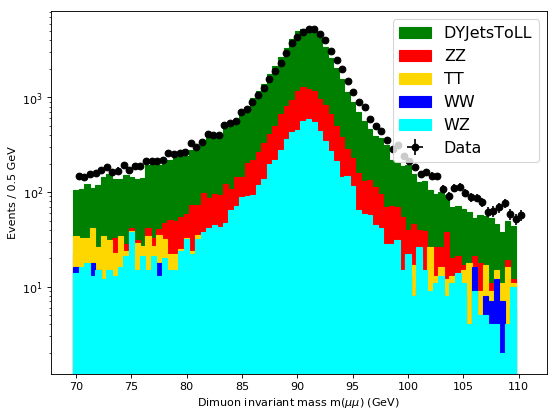

In [17]:
# variable for plotting
VARIABLE = 'InvMass'

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

aHisto   = bulkHisto("SingleMuon")(VARIABLE)
nBins    = len(aHisto.values)
edges    = np.linspace(aHisto.low, aHisto.high, nBins + 1)
width    = (aHisto.high - aHisto.low) / nBins

plotVals = {}
for k in ['DYJetsToLL','ZZ','TT','WW','WZ']:
    #plotVals[k] = [x.toJson()['data']*0.19 for x in bulkHisto(k)(VARIABLE).values]
    plotVals[k] = [x.sum for x in bulkHisto(k)(VARIABLE).values]
    plt.bar(edges[:-1], plotVals[k], width=width, label=k, color=samples[k]['color'], edgecolor=samples[k]['color'], fill=True, log=True)

xdata   = np.linspace(aHisto.low+0.5*width, aHisto.high+0.5*width, nBins)    
#ydata   = [x.toJson()['data'] for x in bulkHisto('SingleMuon')(VARIABLE).values]
ydata   = [x.sum for x in bulkHisto('SingleMuon')(VARIABLE).values]
yerror  = [x**0.5 for x in ydata]

plt.errorbar(xdata, ydata, fmt='ko', label="Data", xerr=width/2, yerr=yerror, ecolor='black')

plt.xlabel('Dimuon invariant mass m($\mu\mu$) (GeV)')
plt.ylabel('Events / 0.5 GeV')
#plt.yscale('log')
plt.legend(loc='upper right', fontsize='x-large', )